# Bayesian Optimization

<!-- This tutorial provides a step-by-step guide to implementing Bayesian optimization from scratch. The Overall story is that we want to find the global minimum/maximum of an unknown function. The procedure consists of first fitting a Gaussian process to the existing samples from the objective function and through that fitted model, finding the most suitable next point to be sampled.

<!-- ## Source
- #### [Github Repo](https://github.com/advafaeian/bayesian-optimization) -->

<!-- ## Introduction
This tutorial assumes that you are already familiar with the following concepts:
* [Bayesian Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)
* [Gaussian Processe](https://distill.pub/2019/visual-exploration-gaussian-processes/)

Basically, a Gaussian process is a multivariate normal variable with infinite dimensions. So if you have for example 2 samples from the objective function: $[x_1, y_1], [x_2, y_2]$, you will fit a bivariate normal variable to these existing data with $y_1, y_2$ as the observations of this bivariate normal variable.

We begin with importing a few libraries: --> -->

In [47]:
#basic imports
import numpy as np
import matplotlib.pyplot as plt


## Objective Function

<!-- Here we are going to find the maximum of the function of $y = sin(\pi x)$. But the caveat is we (actually, the machine) do not have the function :) <br>
We only can sample individual points from the function but with noise. That means we only can sample from $sin(\pi x) + noise$. <br>
Below you can see the code for the objective function. Also, we showed the plot of the function and 100 noisy observations from that function.     -->

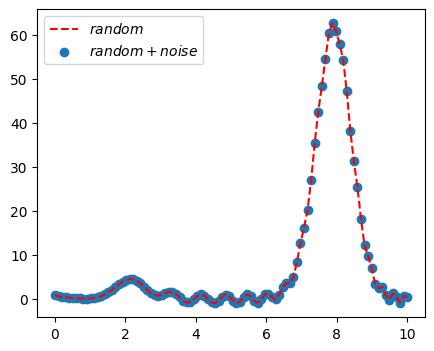

In [48]:
noise = .4
bounds=[0,10] # The interval in which the maximum of the objective function should be found.

def mix_function(x, noise=noise):
    noise = np.random.normal(0, noise)
   # y = np.sin(((x**3)-6*(x**2)+9*x+2)) + np.cos((x-2)**2) +(x-1)**2 + noise
    y = np.sin(x*x) - x**(2*np.sin(x))
    return y

# def mix_function(x, noise=noise):
#     noise = np.random.normal(0, noise)
#     y = np.sin(((x**3)-6*(x**2)+9*x+2)) + np.cos((x-2)**2) +(x-1)**2 + noise
#     return y

def objective_function(x, noise=noise):
    return -mix_function(x,noise) # negation of objective function for minimization

plt.figure(figsize=(5, 4))
X = np.linspace(*bounds, 100)  # generates 100 evenly spread values in the defined domain
means = [objective_function(x, 0) for x in X] # without noise
Y = [objective_function(x) for x in X] #with noise
plt.plot(X, means, "r--", label='$random$') # red line for noise less
plt.scatter(X,Y, label="$random + noise$") # blue scatter with noise
plt.legend(loc='best')
plt.show()

## Radial basis function kernel

<!-- For a multivariate normal variable with $n$ variables, we need $n$ means and a covariance matrix with $n \times n$ elements. The kernel function gives us the covariance matrix. The radial basis function is a kernel, among many, with the following formula: -->
$$K(x, x') = exp(-\frac{{\left\| x - x' \right\|}^2}{2\sigma^2})$$
<!-- The plot shows the kernel outputs for various $x1$ and $x2$. Notice the closer $x1$ and $x2$, the higher the kernel output, which means the higher the covariance between $x1$ and $x2$. -->

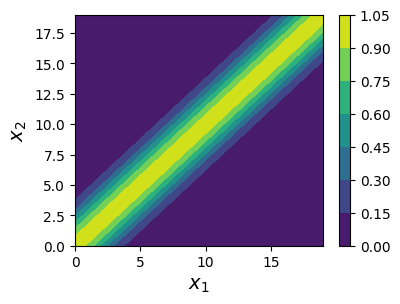

In [49]:
def rbf_kernel(x1, x2, sigma=1):
    """Radial basis function kernel
    Args:
        x1, x2 (float): Two points for which kernel output should be calculated
        sigma (float): Sigma free parameter

    Returns:
        rbf (float): Output of radial basis function kernel
    """
    xx, yy = np.meshgrid(x2, x1)
    rbf =  np.exp(-(xx - yy)**2/(2 * sigma**2))
    return rbf


xs = np.linspace(bounds[0], bounds[1], 20).reshape(-1, 1) # take the previously defined domain
kernel = rbf_kernel(xs,xs)

plt.figure(figsize=(4, 3))
plt.contourf(kernel, cmap="viridis")
plt.colorbar()
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.show()

## Fitting a Gaussian Process to the Data

<!-- This function fits a Gaussian process to the data and returns the parameters for that data, including means and a covariance matrix. <\br>
The fitting procedure involves finding estimates for the new data conditioned on previous data realization.
Here comes the "Bayesian" part: the estimates for the new data are calculated provided the estimates for the previous data. Thus, the function receives the old x and y, `prev_x, prev_y`, in addition to the new data, `X`.

Thus, you have two multivariate normal variables, one for the previous data, and one for the new data
The conditional means and covariance matrix for the new data are as follows: -->

$$\mu_{new|old} = \mu_{new} + \Sigma_{new.old} (\Sigma_{old.old} + \sigma I)^{-1}(x_{old} - \mu_{old})$$
$$ \Sigma_{new|old} = \Sigma_{new.new} - \Sigma_{old.new} (\Sigma_{old.old} + \sigma I)^{-1} \Sigma_{old.new} $$

<!-- Note that for simplicity, here we consider marginal means, $ {\mu_{new}}, {\mu_{old}} $, to be vectors of zeros. $I$ is the identity matrix, a matrix with 1s in the diagonals.

These two formulas are driven in Bishop's Pattern Recognition and Machine Learning book, section 2.3.1. -->

In [50]:

def fitted_gaus(X, prev_x, prev_y, noise):
    """Fitting gaussian processes on new Xs
    Args:
        X (float): New Xs to which the model should be fitted, shape: (n,)
        prev_x (float): Previous Xs to which the model has been already fitted, shape:(m,)
        prev_y (float): Noisy observation for prev_x, shape: (m,)
        noise (float): The noise contributing to the objective funcntion output

    Returns:
        mean_a (float): Means for the new Xs from the fitted gaussian processes, shape: (n,)
        cov_a (float): Covariance matrix the new Xs from the fitted gaussian processes, shape: (n,n)
    """
    # a matlab new point
    # b matlab old point
    sigma_bb = rbf_kernel(prev_x, prev_x) + noise**2 * np.eye(prev_x.shape[0]) ## covariance matrix of previous observariions
    sigma_aa= rbf_kernel(X, X) #kernel matrix of new input point
    sigma_ba = rbf_kernel(prev_x, X) #kernel matrix of previous points with new point
    sigma_ab = rbf_kernel(X, prev_x) # kernel matrix of new point with previous point

    sigma_bb_inv = np.linalg.inv(sigma_bb) #inverse

    mean_a = sigma_ab @ sigma_bb_inv @ prev_y
    cov_a = sigma_aa - (sigma_ab @ sigma_bb_inv @ sigma_ba)

    return mean_a, cov_a


In [51]:
def show_plot(X, Y, noise, title="", obj=True, gaus=True,legend=True):
    """Showing the plot for specific Xs and Ys
    Args:
        X (float): Xs for the plot, shape: (n,)
        Y (float): Ys for the plot, shape: (n,)
        noise (float): The noise contributing to the objective funcntion output
        title (string): The title which should be shown on the plot
        obj (bool): Whether the objective function should be plotted
        gaus (bool): Wheter the Gaussian process should be plotted
        legend (bool):  Whether to show the figure legend, default is set to True

    Returns:
        None
    """
    xs = np.linspace(*bounds, 100)
    ys =[objective_function(x, 0) for x in xs]
    means, cov_mat = fitted_gaus(xs, X, Y, noise)
    sds = np.sqrt(np.diag(cov_mat))
    if obj:
        plt.plot(xs, ys, 'r--', label="$Objective_function$")
    if gaus:
        plt.scatter(X, Y, c="b", label="$Observed_points(X, Y)$")
        plt.plot(xs, means, "y-", label="$\mu_{a|b}$")
        plt.fill_between(xs, means-2*sds, means+2*sds, color ='green', alpha=0.15, label="$\pm2\sigma_{a|b}$")
    if legend:
        plt.legend(loc="best")
    plt.ylim([-5,5])
    plt.title(title)




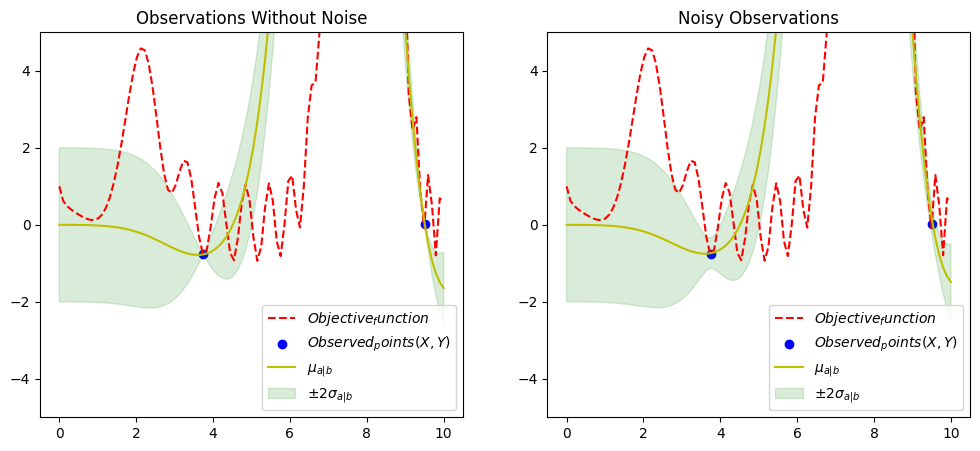

In [52]:
np.random.seed(42)
X = np.random.uniform(*bounds, 3) # generated 3 random values in the range

plt.figure(figsize=(12, 5))

plt.subplot(121)
noise = 0
Y = [objective_function(x, noise) for x in X]
show_plot(X, Y, noise, title="Observations Without Noise")

plt.subplot(122)
noise = .2
Y = [objective_function(x, noise) for x in X]
show_plot(X, Y, noise, title="Noisy Observations")

plt.show()


## Expected Improvement
<!-- This is called the "acquisition function". There are multiple functions used in Bayesian optimization but the most common one is expected improvement. The acquisition function is a function used by the model to recognize which data point should be sampled next from the objective function. When expected improvement is the acquisition function, the next point is the one with the highest expected improvement.
The logic behind this is the average improvement each point can give us, above the maximum value that already has been achieved, $ f^* $. The formula will be: -->

 $$ EI(x) = \int_{-\infty}^{\infty} I(x)\Phi(\epsilon)d\epsilon= (f^* - \mu)\phi(\frac{f^* - \mu}{\sigma})+\sigma\psi(\frac{f^* - \mu}{\sigma}) $$

$\phi$ is th standard normal $CDF$, and $\psi$ is standard normal $PDF$.

<!-- The proof exists [here](http://ash-aldujaili.github.io/blog/2018/02/01/ei/). -->


In [53]:
import scipy

def exp_imp(X, prev_x, prev_y, noise, epcilon):
    """Returns the expected improvment for the new Xs
    Args:
        X (float): New Xs for which the expected improvement should be returned, shape: (n,)
        prev_x (float): Previous Xs to which the model has been already fitted, shape:(m,)
        prev_y (float): Noisy observation for prev_x, shape: (m,)
        noise (float): The noise contributing to the objective funcntion output
        epcilon (float): Exploitation-exploration trade-off parameter

    Returns:
        exp_imp (float): Expected improvemnt for Xs, shape: (n,)
    """
    means, cov_mat = fitted_gaus(X, prev_x, prev_y, noise)
    prev_means, _ = fitted_gaus(prev_x, prev_x, prev_y, noise)
    sds = np.sqrt(np.diag(cov_mat))
    best_mean = np.max(prev_means)
    imp = means - best_mean - epcilon
    Z = imp / sds
    exp_imp = imp * scipy.stats.norm.cdf(Z) + sds * scipy.stats.norm.pdf(Z)
    return exp_imp

In [54]:
def save_plot(X, Y, noise, title="", obj=True, gaus=True, legend=True, new_x=None, i=0):
    """Saves each plot as a frame for the animation
    Args:
        X (float): Xs for the plot, shape: (n,)
        Y (float): Ys for the plot, shape: (n,)
        noise (float): The noise contributing to the objective funcntion output
        title (string): The title which should be shown on the plot
        obj (bool): Whether the objective function should be plotted
        gaus (bool): Wheter the Gaussian process should be plotted
        legend (bool):  Whether to show the figure legend, default is set to True
        new_x (float): The x for which the dash line should be depicted
        i (int): The index for the plot used as the file name

    Returns:
        None
    """
    fig = plt.figure(figsize=(5,4))
    show_plot(X, Y, noise, obj=obj,  gaus=gaus, title=title)
    if new_x:
        plt.axvline(new_x, color='k', linestyle="--")
    plt.savefig(f"./frames/{i}.png", format='png')
    plt.close(fig)

In [65]:
import os
import subprocess
import glob
import shutil

if(os.path.exists("./frames/")):
    shutil.rmtree("./frames/")

os.makedirs("./frames/", exist_ok=True) # creating a folder in which the animation frames will be saved

np.random.seed(5)
noise=.1 # random noise
n = 20 #iterations
epcilon= .1

X = np.random.uniform(*bounds, 1) # creating the first x
Y = [objective_function(x, noise) for x in X] # taking the first noisy sample from the objective function

for i in range(n+3):
  # The first four iterations generate empty or partially filled plots to show the initial steps visually.
    if i == 0:
        save_plot(np.array([]), np.array([]), noise, gaus=False, i=i)
        continue
    if i == 1:
        save_plot(np.array([]), np.array([]), noise, i=i)
        continue
    if i == 2:
        save_plot(np.array([]), np.array([]), noise, obj=False, i=i, title=f"iter {i-2}")
        continue
    if i == 3:
        save_plot(X, Y, noise, new_x=X, obj=False, i=i, title=f"iter {i-2}")
        continue
    xs = np.linspace(*bounds, 100)
    probas = exp_imp(xs, X, Y, noise, epcilon)
    new_x = xs[np.argmax(probas)]
    print(f"iteration {i}: {new_x}")
    X = np.append(X, new_x)
    new_y = objective_function(new_x, noise)
    Y = np.append(Y, new_y)
    save_plot(X, Y, noise, new_x=new_x, obj=False,  title=f"iter {i-1}", i=i)

save_plot(X, Y, noise, new_x=new_x, obj=True, i=i, title=f"iter {i-2}")


subprocess.call([
	'ffmpeg', '-loglevel', 'error', '-y', '-i', './frames/%d.png', '-vf', 'palettegen', './frames/palette.png'
])
subprocess.call([
	'ffmpeg', '-loglevel', 'error','-framerate', '1', '-y', '-i', './frames/%d.png', '-i', './frames/palette.png', '-lavfi', 'paletteuse', 'bayes_opt.gif'
])

print("The objective function is maximized at: ", new_x)


iteration 4: 2.525252525252525
iteration 5: 1.7171717171717171
iteration 6: 2.121212121212121
iteration 7: 2.121212121212121
iteration 8: 2.121212121212121
iteration 9: 2.121212121212121
iteration 10: 2.121212121212121
iteration 11: 2.121212121212121
iteration 12: 2.121212121212121
iteration 13: 2.121212121212121
iteration 14: 2.121212121212121
iteration 15: 2.121212121212121
iteration 16: 2.121212121212121
iteration 17: 2.121212121212121
iteration 18: 2.121212121212121
iteration 19: 2.121212121212121
iteration 20: 10.0
iteration 21: 7.979797979797979
iteration 22: 7.979797979797979
The objective function is maximized at:  7.979797979797979


Now try

<h1> To code <br>
(1)  Probability of Improvement method <br>
(2) Confidence interval bounds method <br>
(3) Comparision over different examples <br>


# Probability of Improvement method

In [67]:
def prob_imp(X, prev_x, prev_y, noise, epsilon):
    """Returns the probability of improvement for the new Xs
    Args:
        X (float): New Xs for which the probability of improvement should be returned, shape: (n,)
        prev_x (float): Previous Xs to which the model has been already fitted, shape:(m,)
        prev_y (float): Noisy observation for prev_x, shape: (m,)
        noise (float): The noise contributing to the objective function output
        epsilon (float): Exploitation-exploration trade-off parameter

    Returns:
        prob_imp (float): Probability of improvement for Xs, shape: (n,)
    """
    means, cov_mat = fitted_gaus(X, prev_x, prev_y, noise)
    prev_means, _ = fitted_gaus(prev_x, prev_x, prev_y, noise)
    sds = np.sqrt(np.diag(cov_mat))
    best_mean = np.max(prev_means)
    Z = (means - best_mean - epsilon) / (sds + 1e-9)
    return scipy.stats.norm.cdf(Z)


In [70]:
import os
import subprocess
import glob
import shutil

if(os.path.exists("./frames/")):
    shutil.rmtree("./frames/")

os.makedirs("./frames/", exist_ok=True) # creating a folder in which the animation frames will be saved

np.random.seed(5)
noise=.1 # random noise
n = 20 #iterations
epcilon= 1

X = np.random.uniform(*bounds, 1) # creating the first x
Y = [objective_function(x, noise) for x in X] # taking the first noisy sample from the objective function

for i in range(n+3):
  # The first four iterations generate empty or partially filled plots to show the initial steps visually.
    if i == 0:
        save_plot(np.array([]), np.array([]), noise, gaus=False, i=i)
        continue
    if i == 1:
        save_plot(np.array([]), np.array([]), noise, i=i)
        continue
    if i == 2:
        save_plot(np.array([]), np.array([]), noise, obj=False, i=i, title=f"iter {i-2}")
        continue
    if i == 3:
        save_plot(X, Y, noise, new_x=X, obj=False, i=i, title=f"iter {i-2}")
        continue
    xs = np.linspace(*bounds, 100)
    probas = prob_imp(xs, X, Y, noise, epcilon)
    new_x = xs[np.argmax(probas)]
    print(f"iteration {i}: {new_x}")
    X = np.append(X, new_x)
    new_y = objective_function(new_x, noise)
    Y = np.append(Y, new_y)
    save_plot(X, Y, noise, new_x=new_x, obj=False,  title=f"iter {i-1}", i=i)

save_plot(X, Y, noise, new_x=new_x, obj=True, i=i, title=f"iter {i-2}")


subprocess.call([
	'ffmpeg', '-loglevel', 'error', '-y', '-i', './frames/%d.png', '-vf', 'palettegen', './frames/palette.png'
])
subprocess.call([
	'ffmpeg', '-loglevel', 'error','-framerate', '1', '-y', '-i', './frames/%d.png', '-i', './frames/palette.png', '-lavfi', 'paletteuse', 'bayes_opt.gif'
])

print("The objective function is maximized at: ", new_x)


iteration 4: 2.8282828282828283
iteration 5: 1.7171717171717171
iteration 6: 10.0
iteration 7: 7.878787878787879
iteration 8: 7.777777777777778
iteration 9: 7.979797979797979
iteration 10: 7.979797979797979
iteration 11: 7.777777777777778
iteration 12: 7.979797979797979
iteration 13: 7.777777777777778
iteration 14: 7.979797979797979
iteration 15: 7.979797979797979
iteration 16: 7.777777777777778
iteration 17: 7.979797979797979
iteration 18: 7.979797979797979
iteration 19: 7.777777777777778
iteration 20: 7.979797979797979
iteration 21: 7.979797979797979
iteration 22: 7.777777777777778
The objective function is maximized at:  7.777777777777778


In [71]:
def upper_conf_bound(X, prev_x, prev_y, noise, kappa):
    """Returns the upper confidence bound (UCB) acquisition values for the new Xs.
    Args:
        X (float): New Xs for which UCB should be returned, shape: (n,)
        prev_x (float): Previous Xs to which the model has been already fitted, shape:(m,)
        prev_y (float): Noisy observation for prev_x, shape: (m,)
        noise (float): The noise contributing to the objective function output
        kappa (float): Exploration-exploitation trade-off parameter

    Returns:
        ucb (float): UCB values for Xs, shape: (n,)
    """
    means, cov_mat = fitted_gaus(X, prev_x, prev_y, noise)
    sds = np.sqrt(np.diag(cov_mat))
    ucb = means + kappa * sds
    return ucb


In [75]:
import os
import subprocess
import glob
import shutil

if(os.path.exists("./frames/")):
    shutil.rmtree("./frames/")

os.makedirs("./frames/", exist_ok=True) # creating a folder in which the animation frames will be saved

np.random.seed(5)
noise=.1 # random noise
n = 20 #iterations
kappa= 10

X = np.random.uniform(*bounds, 1) # creating the first x
Y = [objective_function(x, noise) for x in X] # taking the first noisy sample from the objective function
print(X)
for i in range(n+3):
  # The first four iterations generate empty or partially filled plots to show the initial steps visually.
    if i == 0:
        save_plot(np.array([]), np.array([]), noise, gaus=False, i=i)
        continue
    if i == 1:
        save_plot(np.array([]), np.array([]), noise, i=i)
        continue
    if i == 2:
        save_plot(np.array([]), np.array([]), noise, obj=False, i=i, title=f"iter {i-2}")
        continue
    if i == 3:
        save_plot(X, Y, noise, new_x=X, obj=False, i=i, title=f"iter {i-2}")
        continue
    xs = np.linspace(*bounds, 100)
    probas = upper_conf_bound(xs, X, Y, noise, kappa)
    new_x = xs[np.argmax(probas)]
    print(f"iteration {i}: {new_x}")
    X = np.append(X, new_x)
    new_y = objective_function(new_x, noise)
    Y = np.append(Y, new_y)
    save_plot(X, Y, noise, new_x=new_x, obj=False,  title=f"iter {i-1}", i=i)

save_plot(X, Y, noise, new_x=new_x, obj=True, i=i, title=f"iter {i-2}")


subprocess.call([
	'ffmpeg', '-loglevel', 'error', '-y', '-i', './frames/%d.png', '-vf', 'palettegen', './frames/palette.png'
])
subprocess.call([
	'ffmpeg', '-loglevel', 'error','-framerate', '1', '-y', '-i', './frames/%d.png', '-i', './frames/palette.png', '-lavfi', 'paletteuse', 'bayes_opt.gif'
])

print("The objective function is maximized at: ", new_x)


[2.21993171]
iteration 4: 3.5353535353535355
iteration 5: 0.9090909090909091
iteration 6: 10.0
iteration 7: 7.6767676767676765
iteration 8: 7.474747474747475
iteration 9: 8.181818181818182
iteration 10: 7.979797979797979
iteration 11: 7.979797979797979
iteration 12: 7.979797979797979
iteration 13: 7.979797979797979
iteration 14: 7.979797979797979
iteration 15: 7.979797979797979
iteration 16: 7.979797979797979
iteration 17: 7.979797979797979
iteration 18: 7.979797979797979
iteration 19: 7.979797979797979
iteration 20: 7.979797979797979
iteration 21: 7.979797979797979
iteration 22: 7.979797979797979
The objective function is maximized at:  7.979797979797979
